# Links

Texts: [https://www.kaggle.com/datasets/naderabdalghani/iam-handwritten-forms-dataset](https://www.kaggle.com/datasets/naderabdalghani/iam-handwritten-forms-dataset)

Words: [https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database](https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database)

# Import

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from torch import tensor
from torch.functional import F
from torchvision import transforms


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skimage.morphology import skeletonize
from itertools import product

import pandas as pd
import numpy as np
import os
from PIL import Image
import copy
import cv2

from matplotlib import pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data

In [2]:
with open('iam_words/words.txt', 'r') as f:
    words = f.readlines()
words = [word.strip() for word in words]
words = words[18:-1]
words = [w for w in words if ' err ' not in w]
words = [[w.split(' ')[0], w.split(' ')[-1]] for w in words]
words = [
    [f'iam_words/words/{w.split('-')[0]}/{w.split('-')[0]}-{w.split('-')[1]}/{w}.png', y] for w, y in words]
df = pd.DataFrame(words, columns=['filename', 'word'])
df = df[df['filename'].apply(os.path.exists)]
# Filter out rows where the file cannot be opened
# valid_rows = []
# for _, row in df.iterrows():
#     try:
#         with Image.open(row['filename']) as img:
#             img.verify()  # Verify that the file is a valid image
#         valid_rows.append(row)
#     except Exception as e:
#         print(f"Skipping file {row['filename']} due to error: {e}")

# df = pd.DataFrame(valid_rows, columns=df.columns)
df = df[df['word'].apply(lambda x: len(x) < 10 and x.lower() == x)]
vocab = ' ' + ''.join(sorted(set(''.join(df['word'].values))))
print(vocab)
# df = df.sample(1000)

MAX_LEN = df['word'].apply(len).max()
print(MAX_LEN)
df

 !"#'()*,-./0123456789:;?abcdefghijklmnopqrstuvwxyz
9


,filename,word
2,iam_words/words/a01/a01-000u/a01-000u-00-02.png,to
3,iam_words/words/a01/a01-000u/a01-000u-00-03.png,stop
6,iam_words/words/a01/a01-000u/a01-000u-00-06.png,from
8,iam_words/words/a01/a01-000u/a01-000u-01-01.png,any
9,iam_words/words/a01/a01-000u/a01-000u-01-02.png,more
...,...,...
38299,iam_words/words/e07/e07-072/e07-072-08-06.png,can
38300,iam_words/words/e07/e07-072/e07-072-08-07.png,be
38301,iam_words/words/e07/e07-072/e07-072-09-00.png,obtained
38302,iam_words/words/e07/e07-072/e07-072-09-01.png,at


# Dataset

In [3]:
class HandWritingDataset(Dataset):
    vocab = vocab
    char_to_index = {char: i for i, char in enumerate(vocab)}
    index_to_char = {i: char for i, char in enumerate(vocab)}
    
    def __init__(self, df: pd.DataFrame, augument: bool = False):
        super().__init__()
        self.df = df
        self.augument = augument
        self.compose = transforms.Compose([
            transforms.RandomRotation(5, expand=True, fill=(255,)),
            transforms.RandomAffine(0, translate=(0.05, 0.05), fill=(255,)),
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx) -> tuple[tensor, tensor, int]:
        row = self.df.iloc[idx]
        im = Image.open(row['filename']).convert('L')
        if self.augument:
            im = self.compose(im)
        im = cv2.bitwise_not(np.array(im, dtype=np.uint8))
        im = cv2.resize(im, (64, 32), interpolation=cv2.INTER_CUBIC)
        # _, im = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # im = skeletonize(im).astype(np.uint8)
        im = tensor(np.array(im, dtype=np.float32), dtype=torch.float32).to(device).unsqueeze(0) / 255.0
        label = tensor([self.char_to_index[c] for c in row['word']]).to(device)
        target_length = len(label)

        return im, label, target_length


    @staticmethod
    def decode(output):
        decoded_str = ''
        for index in output:
            if index == 0:
                break
            decoded_str += HandWritingDataset.index_to_char[index.item()]
        return decoded_str

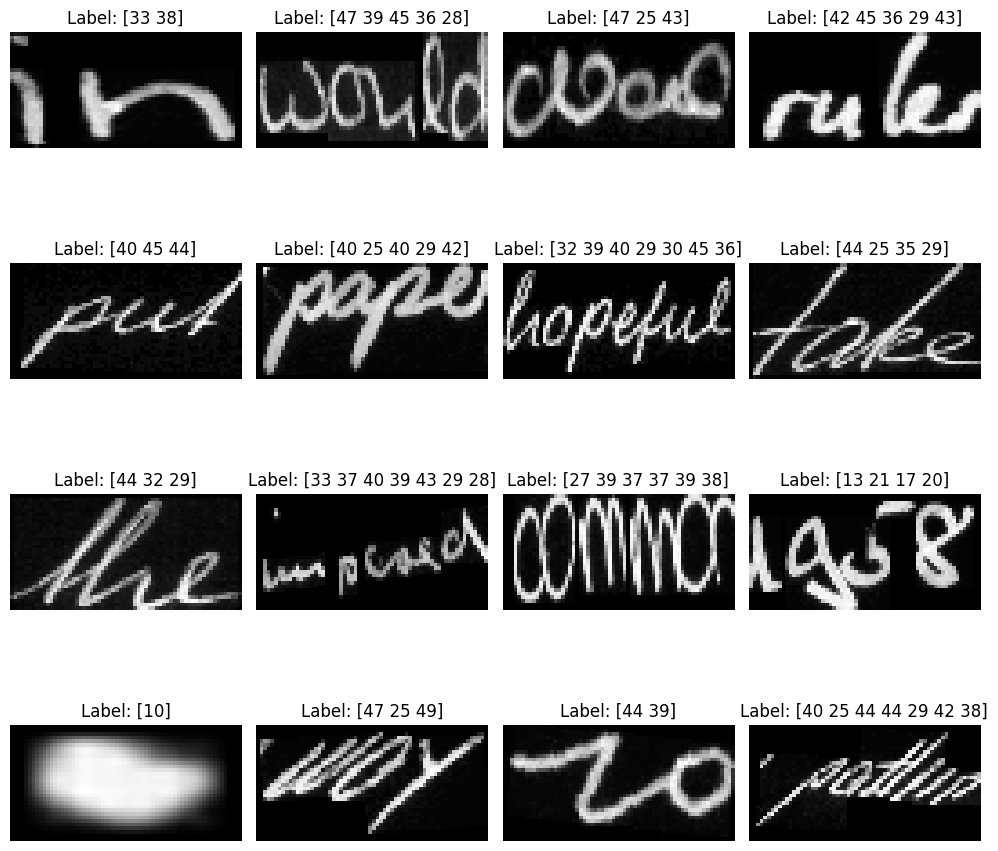

In [4]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, (x, y, tl) in enumerate(HandWritingDataset(df.sample(16), augument=True)):
    ax = axes[i // 4, i % 4]
    ax.imshow(x.squeeze().cpu().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {np.round(y.cpu().numpy(), 2)}")
plt.tight_layout()
plt.show()

# Loader

In [5]:
def collate_fn(batch: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    images, labels, target_lengths = zip(*batch)
    images = torch.stack(images)

    labels = torch.tensor(
        [char for label in labels for char in label], dtype=torch.long).to(device)

    target_lengths = torch.tensor(target_lengths, dtype=torch.long).to(device)

    return images, labels, target_lengths


def getLoaders(df: pd.DataFrame, size: float = 1.0, batch_size: int = 4, not_train_size: float = 0.2) -> tuple[DataLoader, DataLoader, DataLoader]:
    tmpdf = df.sample(int(len(df) * size))

    train_df, test_df = train_test_split(tmpdf, test_size=not_train_size)
    test_df, val_df = train_test_split(test_df, test_size=0.5)
    
    train_dataset = HandWritingDataset(train_df, augument=True)
    test_dataset = HandWritingDataset(test_df)
    val_dataset = HandWritingDataset(val_df)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    return train_loader, test_loader, val_loader

# Model

In [6]:
class HandWritingModel(nn.Module):
    def __init__(self, c: int, h: int, n: int):
        super(HandWritingModel, self).__init__()

        self.conv1 = nn.Conv2d(1, c, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(c)
        self.drop1 = nn.Dropout(0.2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.lstm = nn.LSTM(input_size=16*c, hidden_size=h, num_layers=n, batch_first=True)

        self.output = nn.Linear(h, len(vocab))

        self._init_weights()

    def forward(self, x):
        # print(f'input: {x.shape}')
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.drop1(x)
        x = self.pool1(x)
        # print(f'conv: {x.shape}')


        x = x.permute(0, 3, 2, 1)
        # print(f'permute: {x.shape}')
        x = x.flatten(start_dim=2)
        # print(f'flatten: {x.shape}')
        x, (_, _) = self.lstm(x)
        # print(f'lstm: {x.shape}')

        x = self.output(x)
        x = x.permute(1, 0, 2)
        x = F.log_softmax(x, dim=2)
        # x = F.log_softmax(x + 1e-8, dim=2)
        # print(f'out: {x.shape}')

        return x
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='tanh')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# Training

In [ ]:
def train_model(
    model: HandWritingModel, 
    criterion: nn.CTCLoss, 
    optimizer: optim.Optimizer, 
    train_loader: DataLoader, 
    val_loader: DataLoader, 
    epochs: int = 10
) -> None:
    model.train()
    print(f'|         '*10, end='|\n')
    for epoch in range(epochs):
        train_losses = 0
        i = 0
        for x, y, target_lengths in train_loader:
            optimizer.zero_grad()
            y_pred = model(x)
            batch_size = x.size(0)
            input_lengths = torch.full(size=(batch_size,), fill_value=y_pred.size(0), dtype=torch.long).to(device)
            loss = criterion(y_pred, y, input_lengths, target_lengths)
            if torch.isnan(loss):
                raise Exception("NaN loss detected")
            if i % max(1, len(train_loader.dataset) // (train_loader.batch_size * 100)) == 0:
                print('-', end='')
            train_losses += loss.sum().item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            i += 1

        val_losses = 0
        with torch.no_grad():
            for x, y, target_lengths in val_loader:
                y_pred = model(x)
                batch_size = x.size(0)
                input_lengths = torch.full(size=(batch_size,), fill_value=y_pred.size(0), dtype=torch.long).to(device)
                loss = criterion(y_pred, y, input_lengths, target_lengths)
                if torch.isnan(loss):
                    raise Exception("NaN loss detected")
                val_losses += loss.sum().item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses/len(train_loader.dataset):.3f}     Val_Loss: {val_losses/len(val_loader.dataset):.3f}")

In [8]:
def test_model(model: HandWritingModel, criterion: nn.CTCLoss, test_loader: DataLoader) -> float:
    model.eval()
    test_losses = 0
    for x, y, target_lengths in test_loader:
        y_pred = model(x)
        batch_size = x.size(0)
        input_lengths = torch.full(size=(batch_size,), fill_value=y_pred.size(0), dtype=torch.long).to(device)
        loss = criterion(y_pred, y, input_lengths, target_lengths)
        test_losses += loss.sum().item()
        if torch.isnan(loss):
            raise Exception("NaN loss detected")
    return test_losses / len(test_loader) / test_loader.batch_size

In [9]:
def predict(model: HandWritingModel, sample_df) -> list[tuple[str, str]]:
    model.eval()
    predictions = []
    test_loader = DataLoader(HandWritingDataset(sample_df), batch_size=1, shuffle=False, collate_fn=collate_fn)
    with torch.no_grad():
        for x, y, tl in test_loader:
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=2)
            predictions.append((HandWritingDataset.decode(y_pred), HandWritingDataset.decode(y)))
    return predictions

# Example usage

In [ ]:
criterion = nn.CTCLoss(blank=0, zero_infinity=True).to(device)
model = HandWritingModel(128, 512, 2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

train_loader, test_loader, val_loader = getLoaders(df, size=1.0, batch_size=4, not_train_size=0.2)

In [111]:
train_model(model, criterion, optimizer, train_loader, val_loader, epochs=2)

|         |         |         |         |         |         |         |         |         |         |
------------------------------------------------------------------------------------------------------Epoch 1/2, Loss: 0.630     Val_Loss: 0.617
------------------------------------------------------------------------------------------------------Epoch 2/2, Loss: 0.593     Val_Loss: 0.569


In [109]:
test_loss = test_model(model, criterion, test_loader)
print(f"Test Loss: {test_loss:.3f}")

predictions = predict(model, df.sample(50))
for i in predictions:
    print(i)

Test Loss: 0.722
('t', 'towards')
('', 'the')
(',', ',')
('', 'the')
('', 'a')
('', 'had')
(',', 'who')
('', 'was')
('', 'crowded')
(',', 'the')
('', 'retorted')
('', 'as')
('', ',')
('', 'flower')
('', 'strain')
('', 'no')
('', 'of')
('t', 'burst')
('', '.')
('', "anybody's")
('', 'the')
(',', 'problems')
('', 'us')
('', 'was')
('', 'filmed')
('', 'self')
(',', 'but')
(',', 'from')
('t', 'toes')
(',', ',')
('', 'first')
(',', 'the')
('', 'the')
('', 'the')
('', '90-day')
('t', 'cupboard')
('', 'lapse')
('', 'by')
('', 'president')
(',', ';')
(',', 'even')
('', 'and')
('', ',')
('', 'his')
('', 'a')
('', 'made')
('', 'of')
('t', 'to')
('', 'these')
('', 'by')


# Tuning

In [13]:
criterion = nn.CTCLoss(blank=0, zero_infinity=True).to(device)

tested_parameters = list(product([16, 32, 64, 128], [64, 128, 256], [1, 2]))

train_loader, test_loader, val_loader = getLoaders(df, size=0.03, batch_size=4, not_train_size=0.2)

results = pd.DataFrame({
    'params': tested_parameters,
    'train_loss': 0.0,
    'test_loss': 0.0
})

for i in range(len(results)):
    row = results.iloc[i]
    print(f'c: {row["params"][0]}, h: {row["params"][1]}, n: {row["params"][2]}')
    model = HandWritingModel(row['params'][0], row['params'][1], row['params'][2]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    train_model(model, criterion, optimizer, train_loader, val_loader, epochs=1)
    results.loc[i, 'train_loss'] = test_model(model, criterion, train_loader)
    results.loc[i, 'test_loss'] = test_model(model, criterion, test_loader)

print(results)

c: 16, h: 64, n: 1
|         |         |         |         |         |         |         |         |         |         |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- Epoch 1/1, Loss: 5.220     Val_Loss: 1.095
c: 16, h: 64, n: 2
|         |         |         |         |         |         |         |         |         |         |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- Epoch 1/1, Loss: 4.667     Val_Loss: 1.139


KeyboardInterrupt: 

<Axes: xlabel='params'>

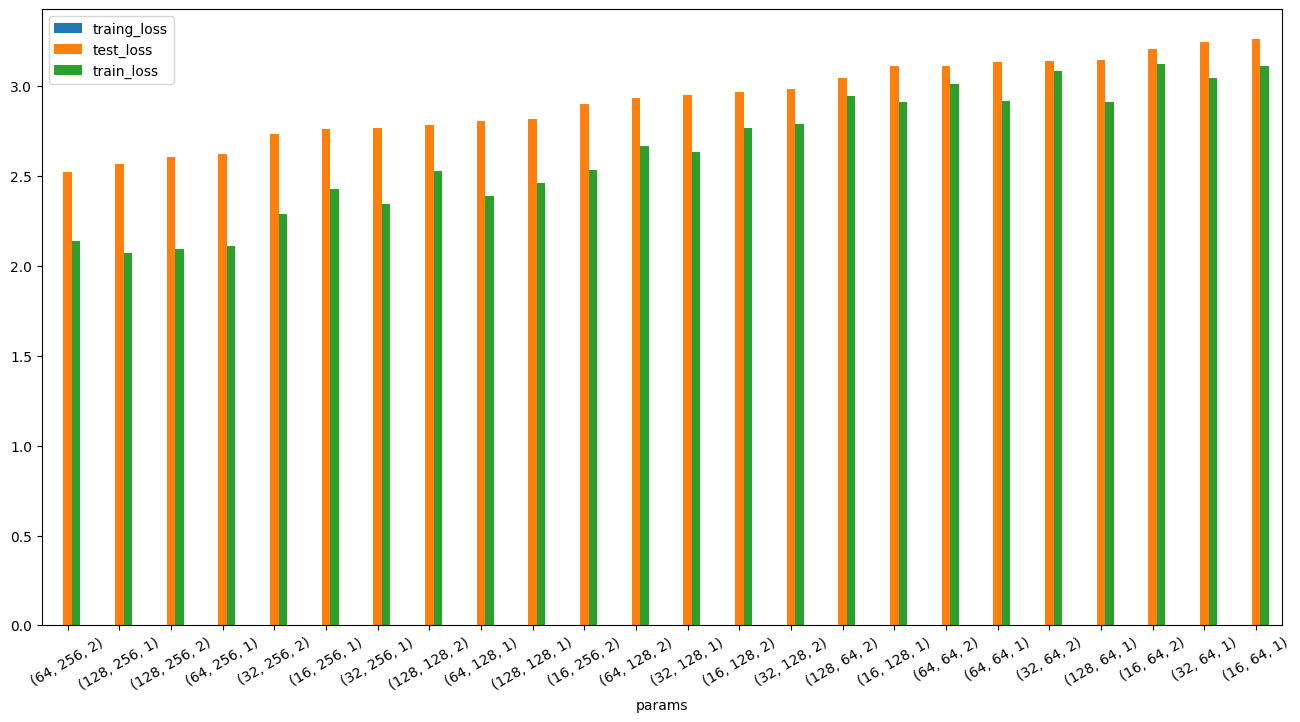

In [ ]:
results = results.sort_values(by='test_loss', ascending=True)

results.set_index('params').plot(kind='bar', figsize=(16, 8), rot=30)
